## The VGG16 model
##### Source: https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/10_Fine-Tuning.ipynb




### Transfer learning
Involves using pre-existing models to train new data on it, saves time and space of the otherwise computationally intensive deep learning problems. 

The key idea for transfer learning is that the pre-trained model like VGG 16's weighted layers are used to extract features and are not updated during training the new data. 

VGG 16 is trained on a large dataset like Imagenet. This is a huge dataset of a multi-tude of different images in diversified categories. It is a 16-layer (convolution and fully connected) network. Usually to implement this model, we would be interested in the first 5 layers, as this will be an efficient feature extractor or for fine tuning. 

##### Source: https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a

In [0]:
# Mount colab notebook to Google drive
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
## IMPORT PACKAGES AND DEFINE A FEW VARIABLES TO BE USED LATER

In [0]:
# define and move to dataset directory
datasetdir = '/content/drive/My Drive/COVID_DL/in'
import os
os.chdir(datasetdir)

# import the needed packages
import matplotlib.pyplot as plt
import matplotlib.image as img
import tensorflow.keras as keras
import numpy as np

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 128

def generators(shape, preprocessing): 
    '''Create the training and validation datasets for 
    a given image shape.
    '''
    imgdatagen = ImageDataGenerator(
        preprocessing_function = preprocessing,
        horizontal_flip = True, 
        validation_split = 0.1,
    )

    height, width = shape

    train_dataset = imgdatagen.flow_from_directory(
        os.getcwd(),
        target_size = (height, width), 
        classes = ('NORMAL','COVID-19','Viral Pneumonia'),
        batch_size = batch_size,
        subset = 'training', 
    )

    val_dataset = imgdatagen.flow_from_directory(
        os.getcwd(),
        target_size = (height, width), 
        classes = ('NORMAL','COVID-19','Viral Pneumonia'),
        batch_size = batch_size,
        subset = 'validation'
    )
    return train_dataset, val_dataset

In [0]:
def plot_history(history, yrange):
    '''Plot loss and accuracy as a function of the epoch,
    for the training and validation datasets.
    '''
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.ylim(yrange)
    plt.legend(loc="lower right")
    
    # Plot training and validation loss per epoch
    plt.figure()

    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Training and validation loss')
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="lower right")

    plt.show()

## FEATURE EXTRACTION WITH MODEL - VGG16

In [0]:
vgg16 = keras.applications.vgg16
vgg = vgg16.VGG16(weights='imagenet')
vgg.summary()

553467904/553467096 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [0]:
vgg16 = keras.applications.vgg16
conv_model = vgg16.VGG16(weights='imagenet', include_top=False)
conv_model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

In [0]:
from keras.preprocessing import image

img_path = '/content/drive/My Drive/COVID_DL/in/NORMAL/NORMAL (1).png'

# loading the image: 
img = image.load_img(img_path, target_size=(224, 224))
# turn it into a numpy array
x = image.img_to_array(img)
print(np.min(x), np.max(x))
print(x.shape)
# expand the shape of the array, 
# a new axis is added at the beginning:
xs = np.expand_dims(x, axis=0)
print(xs.shape)
# preprocess input array for VGG16
xs = vgg16.preprocess_input(xs)
# evaluate the model to extract the features
features = conv_model.predict(xs)
print(features.shape)

Using TensorFlow backend.


0.0 255.0
(224, 224, 3)
(1, 224, 224, 3)
(1, 7, 7, 512)


In [0]:
train_dataset, val_dataset = generators((224,224), preprocessing=vgg16.preprocess_input)

Found 2619 images belonging to 3 classes.
Found 290 images belonging to 3 classes.


In [0]:
conv_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

In [0]:
x = keras.layers.Flatten()(conv_model.output)
# three hidden layers
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
# final softmax layer with three categories
predictions = keras.layers.Dense(3, activation='softmax')(x)

# creating the full model:
full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)
full_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
for layer in conv_model.layers:
    layer.trainable = False

In [0]:
full_model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
full_model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adamax(lr=0.001),
                  metrics=['accuracy'])
history = full_model.fit_generator(
    train_dataset, 
    validation_data = val_dataset,
    steps_per_epoch= train_dataset.samples // batch_size,
    validation_steps= val_dataset.samples // batch_size,
    epochs=5,
)

Epoch 1/5
20/20 [==============================] - 1375s 69s/step - loss: 0.9113 - accuracy: 0.8828 - val_loss: 0.1369 - val_accuracy: 0.9648
Epoch 2/5
20/20 [==============================] - 1334s 67s/step - loss: 0.1340 - accuracy: 0.9599 - val_loss: 0.0461 - val_accuracy: 0.9727
Epoch 3/5
20/20 [==============================] - 1335s 67s/step - loss: 0.0579 - accuracy: 0.9783 - val_loss: 0.0760 - val_accuracy: 0.9648
Epoch 4/5
20/20 [==============================] - 1365s 68s/step - loss: 0.0312 - accuracy: 0.9902 - val_loss: 0.0364 - val_accuracy: 0.9805
Epoch 5/5
20/20 [==============================] - 1367s 68s/step - loss: 0.0230 - accuracy: 0.9920 - val_loss: 0.0504 - val_accuracy: 0.9766


No handles with labels found to put in legend.
No handles with labels found to put in legend.


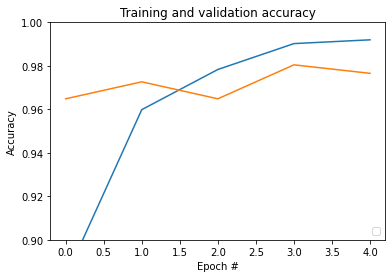

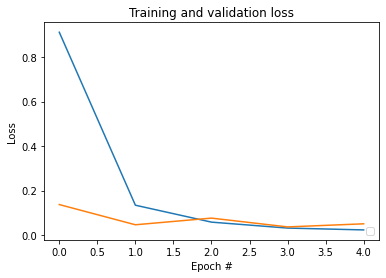

<Figure size 432x288 with 0 Axes>

In [0]:
plot_history(history, yrange=(0.9,1))
plt.savefig("/content/drive/My Drive/COVID_DL/plot.png")

In [0]:
# Save the model
full_model.save_weights('vgg16.h5')

In [0]:
# Evaluate model accuracy on validation dataset
steps_test = val_dataset.n / batch_size
result = full_model.evaluate(val_dataset, steps=steps_test)

# Calculate the accuracy on test set classification of X-Rays
print("Validation-set classification accuracy: {0:.2%}".format(result[1]))
print("Validation-set classification loss: {0:.2%}".format(result[0]))

3/2 [=======================================] - 129s 43s/step - loss: 0.0484 - accuracy: 0.9724
Validation-set classification accuracy: 97.24%
Validation-set classification loss: 4.84%


In [0]:
# Load the saved model
conv_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in conv_model.layers:
    layer.trainable = False
x = keras.layers.Flatten()(conv_model.output)
# three hidden layers
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
# final softmax layer with three categories 
predictions = keras.layers.Dense(3, activation='softmax')(x)
full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)

In [0]:
# load weights of saved model
full_model.load_weights('vgg16.h5')

### MODEL EVALUATION

[[3.0465586e-07 9.9999964e-01 2.0996228e-12]]


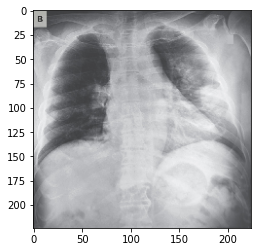

In [0]:
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input

img_path = '/content/drive/My Drive/COVID_DL/in/COVID-19/COVID-19 (20).png'
img = image.load_img(img_path, target_size=(224,224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print(full_model.predict(x))
plt.imshow(img)

In [0]:
# Evaluate the model on all images in training set
import sys

def true_and_predicted_labels(dataset):
    labels = np.zeros((dataset.n,3))
    preds = np.zeros_like(labels)
    for i in range(len(dataset)):
        sys.stdout.write('evaluating batch {}\r'.format(i))
        sys.stdout.flush()
        batch = dataset[i]
        batch_images = batch[0]
        batch_labels = batch[1]
        batch_preds = full_model.predict(batch_images)
        start = i*batch_size
        labels[start:start+batch_size] = batch_labels
        preds[start:start+batch_size] = batch_preds
    return labels, preds

train_labels, train_preds = true_and_predicted_labels(train_dataset)

In [0]:
def plot_covid_score(preds, labels, range=(0,1)):
    # get the covid score for all images
    covid_score = preds[:,2]
    # get the covid score for other images
    # we use the true labels to select other images
    n_covid_score = covid_score[labels[:,0]>0.5]
    # and for covid
    c_covid_score = covid_score[labels[:,0]<0.5]
    # just some plotting parameters
    params = {'bins':100, 'range':range, 'alpha':0.6}
    plt.hist(n_covid_score, **params)
    plt.hist(c_covid_score, **params)
    plt.yscale('log')

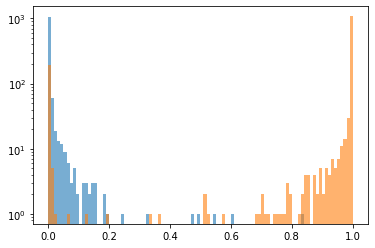

In [0]:
plot_covid_score(train_preds, train_labels)

In [0]:
# For the covid score above we now compute the accuracy
threshold = 0.3

def predicted_labels(preds, threshold):
    '''Turn predictions (floats in the last two dimensions) 
    into labels (0 or 1).'''
    pred_labels = np.zeros_like(preds)
    # covid score lower than threshold: set others label to 1
    # covid score higher than threshold: set others label to 0
    pred_labels[:,0] = preds[:,2]<threshold
    # covid score higher than threshold: set covid label to 1
    # cat score lower than threshold: set covid label to 0
    pred_labels[:,1] = preds[:,2]>=threshold
    return pred_labels


In [0]:
train_pred_labels = predicted_labels(train_preds, threshold)
print('predicted labels:')
print(train_pred_labels)
print('true labels:')
print(train_labels)

predicted labels:
[[0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]
true labels:
[[0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [0]:
# Quantify misclassified examples IN train dataset

def misclassified(labels, pred_labels, print_report=True):
    def report(categ, n_misclassified, n_examples): 
        print('{:<4} {:>3} misclassified samples ({:4.2f}%)'.format(
            categ,
            n_misclassified, 
            100*(1-float(n_misclassified)/n_examples))
        )
    # total number of examples
    n_examples = len(labels)
    # total number of covid
    n_covid = sum(labels[:,0])
    # total number of others
    n_others = sum(labels[:,2])
    # boolean mask for misidentified examples
    mask_all = pred_labels[:,0] != labels[:,0]
    # boolean mask for misidentified covid    
    mask_covid = np.logical_and(mask_all,labels[:,1]>0.5)
    # boolean mask for misidentified others    
    mask_others = np.logical_and(mask_all,labels[:,1]<0.5)
    if print_report:
        report('all', sum(mask_all), n_examples)
        report('covid', sum(mask_covid), n_covid)
        report('other lung images', sum(mask_others), n_others)
    return mask_all, mask_covid, mask_others

_ = misclassified(train_labels, train_pred_labels)

all  208 misclassified samples (92.06%)
covid 200 misclassified samples (83.44%)
other lung images   8 misclassified samples (99.34%)


In [0]:
# Quantify misclassified examples in validation dataset

val_labels, val_preds = true_and_predicted_labels(val_dataset)
val_pred_labels = predicted_labels(val_preds, threshold=0.3)
_ = misclassified(val_labels, val_pred_labels)

all   25 misclassified samples (91.38%)
covid  21 misclassified samples (84.33%)
other lung images   4 misclassified samples (97.01%)


In [0]:
val_pred_labels = predicted_labels(val_preds, 0.3)
_ = misclassified(val_labels, val_pred_labels)

all   24 misclassified samples (91.72%)
covid  20 misclassified samples (85.07%)
other lung images   4 misclassified samples (97.01%)


## VIEW SOME MISCLASSIFIED IMAGES

In [0]:
import sys

dataset = val_dataset
misclassified_imgs = dict(others=[], covid=[])
for i in range(len(dataset)):
    if i%100: 
        sys.stdout.write('evaluating batch {}\r'.format(i))
        sys.stdout.flush()
    batch = dataset[i]
    batch_images = batch[0]
    batch_labels = batch[1]
    batch_preds = full_model.predict(batch_images)
    batch_pred_labels = predicted_labels(batch_preds, threshold=0.85)
    mask_all, mask_covid, mask_others = misclassified(
        batch_labels, 
        batch_pred_labels,
        print_report=False                                  
    )
    misclassified_imgs['others'].extend(batch_images[mask_others])
    misclassified_imgs['covid'].extend(batch_images[mask_covid])

In [0]:
print([(label, len(imgs)) for label,imgs in misclassified_imgs.items()])

[('others', 8), ('covid', 22)]


In [0]:
def plot_images(imgs, i):
    ncols, nrows = (5, 2) 
    start = i*ncols*nrows
    fig = plt.figure( figsize=(ncols*5, nrows*5), dpi=50)
    for i, img in enumerate(imgs[start:start+ncols*nrows]):
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(img)
        plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

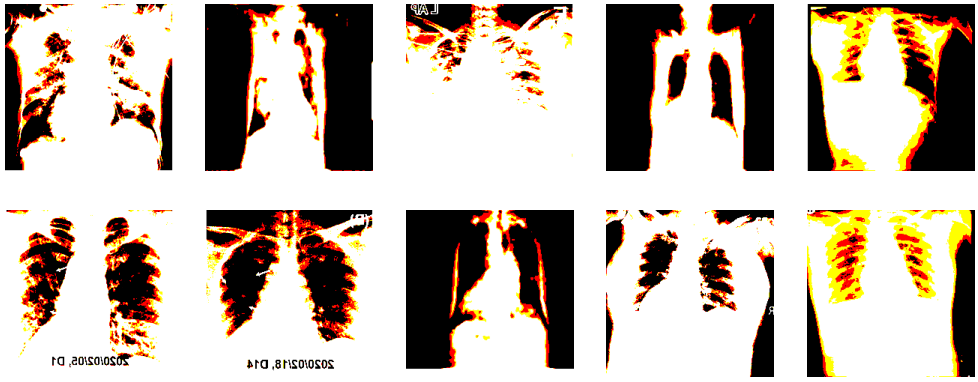

In [0]:
plot_images(misclassified_imgs['covid'],0)
# These images are really bad with an unclear output

In [0]:
# To tackle the nature of images above let us check the version of keras used here first
import keras_applications
keras_applications.__version__

'1.0.8'

In [0]:
# Let us undo preprocessing in images and see

def undo_preprocessing(x):
    mean = [103.939, 116.779, 123.68]
    x[..., 0] += mean[0]
    x[..., 1] += mean[1]
    x[..., 2] += mean[2]
    x = x[..., ::-1]

a = np.arange(12).reshape(2,2,3)
print(a)

a[...,::-1]


[[[ 0  1  2]
  [ 3  4  5]]

 [[ 6  7  8]
  [ 9 10 11]]]


array([[[ 2,  1,  0],
        [ 5,  4,  3]],

       [[ 8,  7,  6],
        [11, 10,  9]]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


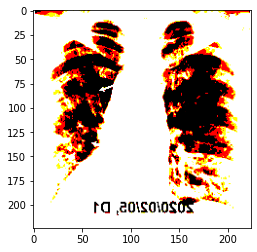

In [0]:
# Now let's try our unprocessing function on one image
img = misclassified_imgs['covid'][5]
plt.imshow(img)

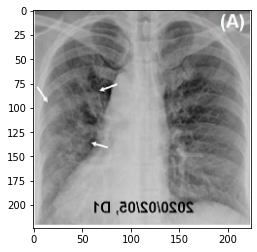

In [0]:
import copy
new_img = copy.copy(img)
undo_preprocessing(new_img)
plt.imshow(new_img.astype('int'))

# This function created here works as expected and can be applied to the other images now

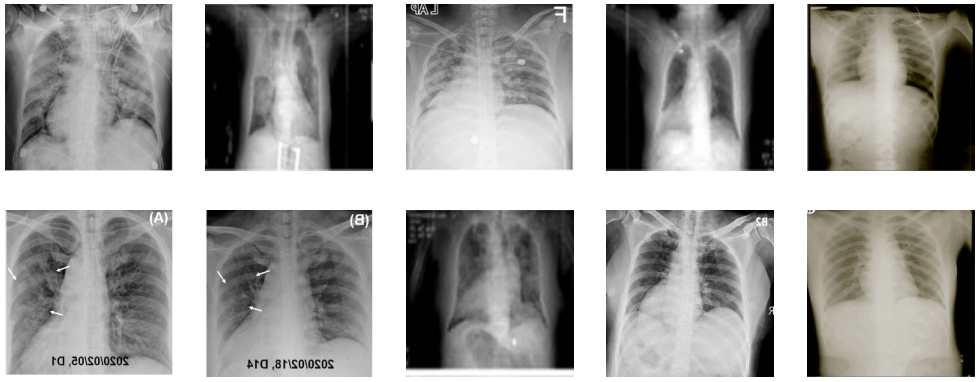

In [0]:
def plot_images(imgs, i):
    ncols, nrows = (5, 2) 
    start = i*ncols*nrows
    fig = plt.figure( figsize=(ncols*5, nrows*5), dpi=50)
    for i, img in enumerate(imgs[start:start+ncols*nrows]):
        img_unproc = copy.copy(img)
        undo_preprocessing(img_unproc)
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(img_unproc.astype('int'))
        plt.axis('off')

plot_images(misclassified_imgs['covid'],0)

## BIBLIOGRAPHY (only for the code)

##### Code adopted from https://thedatafrog.com/en/articles/image-recognition-transfer-learning/

##### Undertsanding the model and the various parameters involved https://www.jeremyjordan.me/evaluating-a-machine-learning-model/

##### Code adopted and modified in some places 
https://colab.research.google.com/github/Hvass-Labs/TensorFlow-Tutorials/blob/master/10_Fine-Tuning.ipynb
